In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
  !pip install unsloth
else:
  # Do this only in Colab notebooks! Otherwise use pip install unsloth
  !pip install -- no-deps bitsandbytes accelerate xformers == 0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
  !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
  !pip install -- no-deps unsloth
!pip install snac

In [ ]:
!pip install snac

In [ ]:
!pip install unsloth


In [1]:
!pip install transformers datasets torchaudio unsloth nrclex gensim gTTS nltk

In [2]:
!pip install --upgrade smart_open


In [3]:
pip install --upgrade gensim

In [ ]:
from unsloth import FastLanguageModel
import torch
dtype = None
load_in_4bit = True

model, tokenizer = FastLanguageModel.from_pretrained(
  model_name = "unsloth/orpheus-3b-0.1-ft-unsloth-bnb-4bit",

  max_seq_length= 2048,
  dtype = dtype,
  load_in_4bit = load_in_4bit,
)

<ipython-input-26-536aedb7322d>:1: UserWarning: WARNING: Unsloth should be imported before transformers to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
Unsloth: Failed to patch Gemma3ForConditionalGeneration.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/235 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/5.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/22.8M [00:00<?, ?B/s]

In [ ]:
model = FastLanguageModel.get_peft_model(
  model,
  r = 64,
  target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
  "gate_proj", "up_proj", "down_proj",],
  lora_alpha = 64,
  lora_dropout = 0,
  bias = "none",
  use_gradient_checkpointing = "unsloth",
  random_state = 3407,
  use_rslora = False,
  loftq_config = None,
)

Unsloth 2025.3.19 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = {"audio": [], "text": []}
!pwd
# Open your text file (adjust the filename as needed)
with open("/content/drive/MyDrive/TTS/000010.TXT", "r", encoding="utf-8-sig") as f:
    lines = f.readlines()

# Process the file two lines at a time (skip the duplicate transcript)
for i in range(0, len(lines), 2):
    # Strip any extra whitespace/newlines
    line = lines[i].strip()
    if not line:
        continue  # Skip empty lines
    # Split by tab to separate the ID and the transcript
    parts = line.split("\t")
    print(parts)
    if len(parts) < 2:
        continue  # Skip lines that don't have both an ID and a transcript
    file_id, transcript = parts[0], parts[1]
    # Create the audio path using the file ID
    audio_path = f"/content/drive/MyDrive/TTS/SESSION0/{file_id}.WAV"
    data["audio"].append(audio_path)
    data["text"].append(transcript)

print(data)


/content
['000010001', 'There were barrels of wine in the huge cellar.']
['000010002', 'She won a car because she was the twelfth person to call the radio station.']
['000010003', 'As they walked back, they were shocked to see a pack of stray dogs circling around the car.']
['000010005', 'Heavy rains caused a flood in the village.']
['000010006', 'He gulped down his beer.']
['000010007', 'Some people go to court to fight for their principles.']
['000010008', 'I get free snacks whenever I go to the supermarket.']
['000010009', 'Melissa passed her number to the young man.']
['000010010', 'The child divulged all his secrets to his best friend.']
['000010011', 'This kind of packaging can pose a danger to animals.']
['000010012', 'They tried to keep it a secret, but he was able to figure everything out.']
['000010013', 'The dwarf crafted a sharp sword and a tough shield for the knight.']
['000010014', 'My father fired the star worker.']
['000010015', 'Song sheets for xylophones are on the s

In [ ]:

from datasets import load_dataset, Dataset, Audio
# dataset = load_dataset("MrDragonFox/Elise", split = "train")
dataset = Dataset.from_dict(data)
dataset = dataset.cast_column("audio", Audio(sampling_rate=44100))

In [ ]:
print(dataset.features)


{'audio': Audio(sampling_rate=44100, mono=True, decode=True, id=None), 'text': Value(dtype='string', id=None)}


In [ ]:
print(dataset.features)


{'audio': Audio(sampling_rate=44100, mono=True, decode=True, id=None), 'text': Value(dtype='string', id=None)}


In [ ]:
from snac import SNAC
snac_model = SNAC.from_pretrained("hubertsiuzdak/snac_24khz")
snac_model = snac_model.to("cuda")

config.json:   0%|          | 0.00/300 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/79.5M [00:00<?, ?B/s]

In [ ]:
#@title Tokenisation Function

import locale
import torchaudio.transforms as T
import os
import torch
from snac import SNAC
locale.getpreferredencoding = lambda: "UTF-8"
ds_sample_rate = dataset[0]["audio"]["sampling_rate"]

snac_model = SNAC.from_pretrained("hubertsiuzdak/snac_24khz")
snac_model = snac_model.to("cuda")

def tokenise_audio(waveform):
  waveform = torch.from_numpy(waveform).unsqueeze(0)
  waveform = waveform.to(dtype=torch.float32)
  resample_transform = T.Resample(orig_freq=ds_sample_rate, new_freq=24000)
  waveform = resample_transform(waveform)

  waveform = waveform.unsqueeze(0).to("cuda")



  #generate the codes from snac
  with torch.inference_mode():
    codes = snac_model.encode(waveform)

  all_codes = []
  for i in range(codes[0].shape[1]):
    all_codes.append(codes[0][0][i].item()+128266)
    all_codes.append(codes[1][0][2*i].item()+128266+4096)
    all_codes.append(codes[2][0][4*i].item()+128266+(2*4096))
    all_codes.append(codes[2][0][(4*i)+1].item()+128266+(3*4096))
    all_codes.append(codes[1][0][(2*i)+1].item()+128266+(4*4096))
    all_codes.append(codes[2][0][(4*i)+2].item()+128266+(5*4096))
    all_codes.append(codes[2][0][(4*i)+3].item()+128266+(6*4096))
  return all_codes


def add_codes(example):
  # Always initialize codes_list to None
  codes_list = None

  try:
    answer_audio = example.get("audio")
    # If there's a valid audio array, tokenise it
    if answer_audio and "array" in answer_audio:
      audio_array = answer_audio["array"]
      codes_list = tokenise_audio(audio_array)
  except Exception as e:
    print(f"Skipping row due to error: {e}")
    # Keep codes_list as None if we fail
  example["codes_list"] = codes_list

  return example

dataset = dataset.map(add_codes, remove_columns=["audio"])

tokeniser_length = 128256
start_of_text = 128000
end_of_text = 128009

start_of_speech = tokeniser_length + 1
end_of_speech = tokeniser_length + 2

start_of_human = tokeniser_length + 3
end_of_human = tokeniser_length + 4

start_of_ai = tokeniser_length + 5
end_of_ai = tokeniser_length + 6
pad_token = tokeniser_length + 7

audio_tokens_start = tokeniser_length + 10

dataset = dataset.filter(lambda x: x["codes_list"] is not None)
dataset = dataset.filter(lambda x: len(x["codes_list"]) > 0)

def remove_duplicate_frames(example):
  vals = example["codes_list"]
  if len(vals) % 7 != 0:
    raise ValueError("Input list length must be divisible by 7")

  result = vals[:7]

  removed_frames = 0
  for i in range(7, len(vals), 7):
    current_first = vals[i]
    previous_first = result[-7]

    if current_first != previous_first:
      result.extend(vals[i:i+7])
    else:
      removed_frames += 1

  example["codes_list"] = result

  return example

dataset = dataset.map(remove_duplicate_frames)


tok_info = ''' *** HERE you can modify the text prompt
If you are training a multi-speaker model (e.g., canopylabs/orpheus-3b-0.1-ft),
ensure that the dataset includes a "source" field and format the input accordingly:
- Single-speaker: f"{example['text']}"
- Multi-speaker: f"{example['source']}: {example['text']}"
'''
print(tok_info)

def create_input_ids(example):
  # Determine whether to include the source field
  text_prompt = f"{example['source']}: {example['text']}" if "source" in example else example["text"]

  text_ids = tokenizer.encode(text_prompt, add_special_tokens=True)
  text_ids.append(end_of_text)

  example["text_tokens"] = text_ids
  input_ids = (
    [start_of_human]
    + example["text_tokens"]
    + [end_of_human]
    + [start_of_ai]
    + [start_of_speech]
    + example["codes_list"]
    + [end_of_speech]
    + [end_of_ai]
  )
  example["input_ids"] = input_ids
  example["labels"] = input_ids
  example["attention_mask"] = [1] * len(input_ids)

  return example

dataset = dataset.map(create_input_ids, remove_columns=["text", "codes_list"])
columns_to_keep = ["input_ids", "labels", "attention_mask"]
columns_to_remove = [col for col in dataset.column_names if col not in columns_to_keep]

dataset = dataset.remove_columns(columns_to_remove)

Parameter 'function'=<function add_codes at 0x7eaf04944680> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/353 [00:00<?, ? examples/s]

Filter:   0%|          | 0/353 [00:00<?, ? examples/s]

Filter:   0%|          | 0/353 [00:00<?, ? examples/s]

Map:   0%|          | 0/353 [00:00<?, ? examples/s]

 *** HERE you can modify the text prompt
If you are training a multi-speaker model (e.g., canopylabs/orpheus-3b-0.1-ft),
ensure that the dataset includes a "source" field and format the input accordingly:
- Single-speaker: f"{example['text']}"
- Multi-speaker: f"{example['source']}: {example['text']}"



Map:   0%|          | 0/353 [00:00<?, ? examples/s]

In [ ]:
from transformers import TrainingArguments, Trainer,DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

trainer = Trainer(
  model = model,
  train_dataset = dataset,
  args = TrainingArguments(
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = 4,
    warmup_steps = 5,
    num_train_epochs = 3, # Set this for 1 full training run.
    max_steps = 60,
    learning_rate = 2e-4,
    fp16= not is_bfloat16_supported(),
    bf16 = is_bfloat16_supported(),
    logging_steps = 1,
    optim = "adamw_8bit",
    weight_decay = 0.01,
    lr_scheduler_type = "linear",
    seed = 3407,
    output_dir = "outputs",
    report_to = "none", # Use this for WandB etc
  ),
)

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 353 | Num Epochs = 1 | Total steps = 60
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 4 x 1) = 4
 "-____-"     Trainable parameters = 97,255,424/3,000,000,000 (3.24% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,5.077200
2,5.336100
3,5.172700
4,5.326500
5,5.180400
6,5.033100
7,4.984300
8,4.898000
9,4.955500
10,4.789600


In [ ]:
import scipy.io.wavfile as wav

# Define a function to save audio
def save_audio(audio_data, filename="output.wav", sample_rate=24000):
    # Convert audio data to numpy array if it's not already
    audio_data = audio_data.detach().squeeze().cpu().numpy()
    wav.write(filename, sample_rate, audio_data)

Word2Vec Version


In [ ]:
import locale

# Patch locale.getpreferredencoding if it's been monkeypatched
if isinstance(locale.getpreferredencoding, type(lambda: None)):
    original_getpreferredencoding = locale.getpreferredencoding

    def patched_getpreferredencoding(do_setlocale=True):
        return original_getpreferredencoding()

    locale.getpreferredencoding = patched_getpreferredencoding


In [3]:
from gensim.models import KeyedVectors
import nltk
import string


nltk.download('punkt')
nltk.download('punkt_tab')
w2v_path = "/content/drive/MyDrive/TTS/GoogleNews-vectors-negative300.bin.gz"
word_vectors = KeyedVectors.load_word2vec_format(w2v_path, binary=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
import torch
import torch.nn as nn
from transformers import BertModel
from transformers import AutoModelForSequenceClassification, AutoConfig,AutoModel


class BertClassifier(nn.Module):
    def __init__(self, model_name="distilbert-base-uncased", num_labels=4, dropout_prob=0.3, num_dropouts=3):
        super(BertClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.num_dropouts = num_dropouts
        self.dropouts = nn.ModuleList([nn.Dropout(dropout_prob) for _ in range(num_dropouts)])
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        out_1 = outputs.last_hidden_state[:, 0]

        drop_list_out = [self.classifier(dropout(out_1)) for dropout in self.dropouts]
        logits = torch.stack(drop_list_out, dim=0).mean(dim=0)

        return logits


In [7]:
from transformers import BertForSequenceClassification, RobertaForSequenceClassification, BertTokenizer, RobertaTokenizer
import torch
import torch
from transformers import AutoTokenizer
import torch.nn as nn
from transformers import AutoModel

roberta_model = RobertaForSequenceClassification.from_pretrained('/content/drive/MyDrive/TTS/sentiment_roberta_model')
roberta_tokenizer = RobertaTokenizer.from_pretrained('/content/drive/MyDrive/TTS/sentiment_roberta_model')
# bert_model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/TTS/emotion_bert_model')
bert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model2 = BertClassifier(model_name="distilbert-base-uncased", num_labels=4).to(device)
model2.load_state_dict(torch.load("/content/drive/MyDrive/TTS/bert_classifier_2.pt", map_location=device))
model2.eval()
model2.to(device)
# bert_model.to(device)
roberta_model.to(device)

label_mapping_emotion = {'joy': 0, 'sad': 1, 'anger': 2, 'fear': 3}
label_mapping_sentiment = {'negative': 0, 'neutral': 1, 'positive': 2}
emotions = list(label_mapping_emotion.keys())
sentiments = list(label_mapping_sentiment.keys())


def predict_sample_text(text):
    b_input = bert_tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    b_input_ = b_input['input_ids'].to(device)
    b_att_mask = b_input['attention_mask'].to(device)

    with torch.no_grad():
        b_output = model2(b_input_, attention_mask=b_att_mask)
        print(b_output)
        b_pred = torch.argmax(b_output, dim=1).cpu().numpy()[0]


    r_input = roberta_tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    r_input_ = r_input['input_ids'].to(device)
    r_att_mask = r_input['attention_mask'].to(device)

    with torch.no_grad():
        r_output = roberta_model(r_input_, attention_mask=r_att_mask)
        print(r_output)
        r_pred = torch.argmax(r_output.logits, dim=1).cpu().numpy()[0]

    return emotions[b_pred], sentiments[r_pred]


emotion_synonyms = {
    "sad": [
        "sad", "unhappy", "sorrowful", "depressed", "melancholy", "downcast", "gloomy", "despondent",
        "miserable", "blue", "heartbroken", "grief-stricken", "dismal", "forlorn", "woeful", "low-spirited",
        "morose", "downhearted", "disheartened", "tearful", "heavy-hearted", "dejected"
    ],
    "anger": [
        "angry", "furious", "irritated", "enraged", "rage", "mad", "annoyed", "agitated", "exasperated",
        "infuriated", "incensed", "resentful", "outraged", "hostile", "fuming", "wrathful", "cross",
        "frustrated", "vengeful", "bitter", "displeased", "provoked", "indignant"
    ],
    "joy": [
        "happy", "joyful", "cheerful", "elated", "excited", "content", "delighted", "glad", "ecstatic",
        "jubilant", "euphoric", "pleased", "merry", "radiant", "thrilled", "overjoyed", "blissful",
        "satisfied", "sunny", "buoyant", "chirpy", "lighthearted", "gleeful","happiness"
    ],
    "fear": [
        "afraid", "scared", "fearful", "terrified", "nervous", "anxious", "panicked", "frightened",
        "apprehensive", "alarmed", "worried", "jittery", "startled", "spooked", "uneasy", "horrified",
        "timid", "paranoid", "shaken", "tense", "petrified", "dreadful", "cowardly"
    ]
}

def punctuate_sentence(tokens, scores, emotion, sentiment, threshold=0.3):

  emotion_punct = {

    "sad": {
        "positive": ",",
        "negative": ".",
        "neutral": ","
    },
    "anger": {
        "positive": "!",
        "negative": "!,",
        "neutral": "."
    },
    "joy": {
        "positive": "!",
        "negative": "!,",
        "neutral": ","
    },
    "fear": {
        "positive": "?",
        "negative": ".",
        "neutral": ","
    }
}



  emotion = emotion.lower()
  sentiment = sentiment.lower()

  if emotion in emotion_punct and sentiment in emotion_punct[emotion]:
      punct = emotion_punct[emotion][sentiment]

  store_word = []

  for i in range(len(tokens)):
      word = tokens[i]
      score = scores[i]

      if score > threshold:
          enhanced_word = word + punct
      else:
          enhanced_word = word

      store_word.append(enhanced_word)

  enhanced_sentence = ' '.join(store_word)
  return enhanced_sentence


sentences = [

    ("I am excited, but also nervous about what is next", "joy", "mixed"),
    ("The silence is comforting, yet kind of sad", "sadness", "mixed"),
    ("I am scared, but this might be the opportunity of a lifetime", "fear", "mixed"),

]



for sentence, _, _ in sentences:
    emotion, sentiment = predict_sample_text(sentence)
    print(emotion,sentiment)
    # Tokenize and clean
    tokens = nltk.word_tokenize(sentence.lower())
    tokens = [word for word in tokens if word not in string.punctuation]

    # Compute scores
    scores = []
    for word in tokens:
        if word in word_vectors:
            try:
                w2vemo_score = 0.0
                # print(emotion_synonyms['sad'])
                emo_sym=emotion_synonyms.get(emotion)

                for synonym in emo_sym:
                  if synonym in word_vectors:
                    outscore=word_vectors.similarity(word, synonym)
                    if outscore>w2vemo_score:
                        # print("yes")
                        w2vemo_score=outscore
                        # print(w2vemo_score)
                scores.append(w2vemo_score)
            except KeyError:
                scores.append(0.0)
        else:
            scores.append(0.0)


    # Print enhanced sentences
    print(scores)
    enhanced = punctuate_sentence(tokens, scores, emotion, sentiment)
    print(f"Enhanced Sentence for '{sentence}' (Emotion: {emotion}, Sentiment: {sentiment}):")
    print(enhanced)
    print()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tensor([[ 2.2763, -2.8902,  2.4308, -1.7474]], device='cuda:0')
SequenceClassifierOutput(loss=None, logits=tensor([[ 2.3202,  0.5329, -3.0075]], device='cuda:0'), hidden_states=None, attentions=None)
anger negative
[0.22592062, 0.19289231, 0.3551922, 0.2410793, 0.16261595, 0.480765, 0.21667595, 0.34531656, 0.11863563, 0.087030016]
Enhanced Sentence for 'I am excited, but also nervous about what is next' (Emotion: anger, Sentiment: negative):
i am excited!, but also nervous!, about what!, is next

tensor([[-1.8893,  2.6328,  1.4354, -2.8428]], device='cuda:0')
SequenceClassifierOutput(loss=None, logits=tensor([[ 1.5542,  1.3250, -3.1404]], device='cuda:0'), hidden_states=None, attentions=None)
sad negative
[0.2208411, 0.3442993, 0.19650376, 0.42647085, 0.18518351, 0.28827375, 0.0, 0.99999994]
Enhanced Sentence for 'The silence is comforting, yet kind of sad' (Emotion: sad, Sentiment: negative):
the silence. is comforting. yet kind of sad.

tensor([[ 4.4911, -1.2634, -1.5131, -1.5770]], 

In [ ]:


# Combine both sentences into prompts list
proms = [
    f"{sentence}",
    f"{enhanced}",
]
k=0
for i in proms:

  prompts = [
  f"{i}"]

  chosen_voice = None

  #@title Run Inference

  FastLanguageModel.for_inference(model) # Enable native 2x faster inference

  # Moving snac_model cuda to cpu
  snac_model.to("cpu")

  prompts_= [(f"{chosen_voice}: " + p) if chosen_voice else p for p in prompts]

  all_input_ids = []

  for prompt in prompts_:
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids
    all_input_ids.append(input_ids)

  start_token = torch.tensor([[ 128259]], dtype=torch.int64) # Start of human
  end_tokens = torch.tensor([[128009, 128260]], dtype=torch.int64) # End of text, End of human


  all_modified_input_ids = []
  for input_ids in all_input_ids:
    modified_input_ids = torch.cat([start_token, input_ids, end_tokens], dim=1) # SOH SOT Text EOT EOH
    all_modified_input_ids.append(modified_input_ids)

  all_padded_tensors = []
  all_attention_masks = []
  max_length = max([modified_input_ids.shape[1] for modified_input_ids in all_modified_input_ids])
  for modified_input_ids in all_modified_input_ids:
    padding = max_length - modified_input_ids.shape[1]
    padded_tensor = torch.cat([torch.full((1, padding), 128263, dtype=torch.int64), modified_input_ids], dim=1)
    attention_mask = torch.cat([torch.zeros((1, padding), dtype=torch.int64), torch.ones((1, modified_input_ids.shape[1]), dtype=torch.int64)], dim=1)
    all_padded_tensors.append(padded_tensor)
    all_attention_masks.append(attention_mask)

  all_padded_tensors = torch.cat(all_padded_tensors, dim=0)
  all_attention_masks = torch.cat(all_attention_masks, dim=0)

  input_ids = all_padded_tensors.to("cuda")
  attention_mask = all_attention_masks.to("cuda")
  generated_ids = model.generate(
    input_ids=input_ids,
    attention_mask=attention_mask,
    max_new_tokens=1200,
    do_sample=True,
    temperature=0.6,
    top_p=0.95,
    repetition_penalty=1.1,
    num_return_sequences=1,
    eos_token_id=128258,
    use_cache = True
  )

  token_to_find = 128257
  token_to_remove = 128258

  token_indices = (generated_ids == token_to_find).nonzero(as_tuple=True)

  if len(token_indices[1]) > 0:
    last_occurrence_idx = token_indices[1][-1].item()
    cropped_tensor = generated_ids[:, last_occurrence_idx+1:]
  else:
    cropped_tensor = generated_ids

  mask = cropped_tensor != token_to_remove

  processed_rows = []


  for row in cropped_tensor:
    masked_row = row[row != token_to_remove]
    processed_rows.append(masked_row)

  code_lists = []

  for row in processed_rows:
    row_length = row.size(0)
    new_length = (row_length // 7) * 7
    trimmed_row = row[:new_length]
    trimmed_row = [t - 128266 for t in trimmed_row]
    code_lists.append(trimmed_row)



  def redistribute_codes(code_list):
    layer_1 = []
    layer_2 = []
    layer_3 = []
    for i in range((len(code_list)+1)//7):
      layer_1.append(code_list[7*i])
      layer_2.append(code_list[7*i+1]-4096)
      layer_3.append(code_list[7*i+2]-(2*4096))
      layer_3.append(code_list[7*i+3]-(3*4096))
      layer_2.append(code_list[7*i+4]-(4*4096))
      layer_3.append(code_list[7*i+5]-(5*4096))
      layer_3.append(code_list[7*i+6]-(6*4096))
    codes = [torch.tensor(layer_1).unsqueeze(0),
      torch.tensor(layer_2).unsqueeze(0),
      torch.tensor(layer_3).unsqueeze(0)]

  # codes = [c.to("cuda") for c in codes]
    audio_hat = snac_model.decode(codes)
    return audio_hat

  my_samples = []
  for code_list in code_lists:
    samples = redistribute_codes(code_list)
    my_samples.append(samples)
  from IPython.display import display, Audio
  if len(prompts) != len(my_samples):
    raise Exception("Number of prompts and samples do not match")

  else:
    for i in range(len(my_samples)):
      print(prompts[i])
      # print("EHEHQIUEH")
      samples = my_samples[i]
      display(Audio(samples.detach().squeeze().to("cpu").numpy(), rate=24000))
      save_audio(samples, f"generated_audio_{k+1}.wav")
      k+=1
    # Clean up to save RAM
  del my_samples,samples


I am excited, but also nervous about what is next


i am excited!, but also nervous!, about what!, is next



Comparing /content/generated_audio_1.wav and /content/generated_audio_2.wav


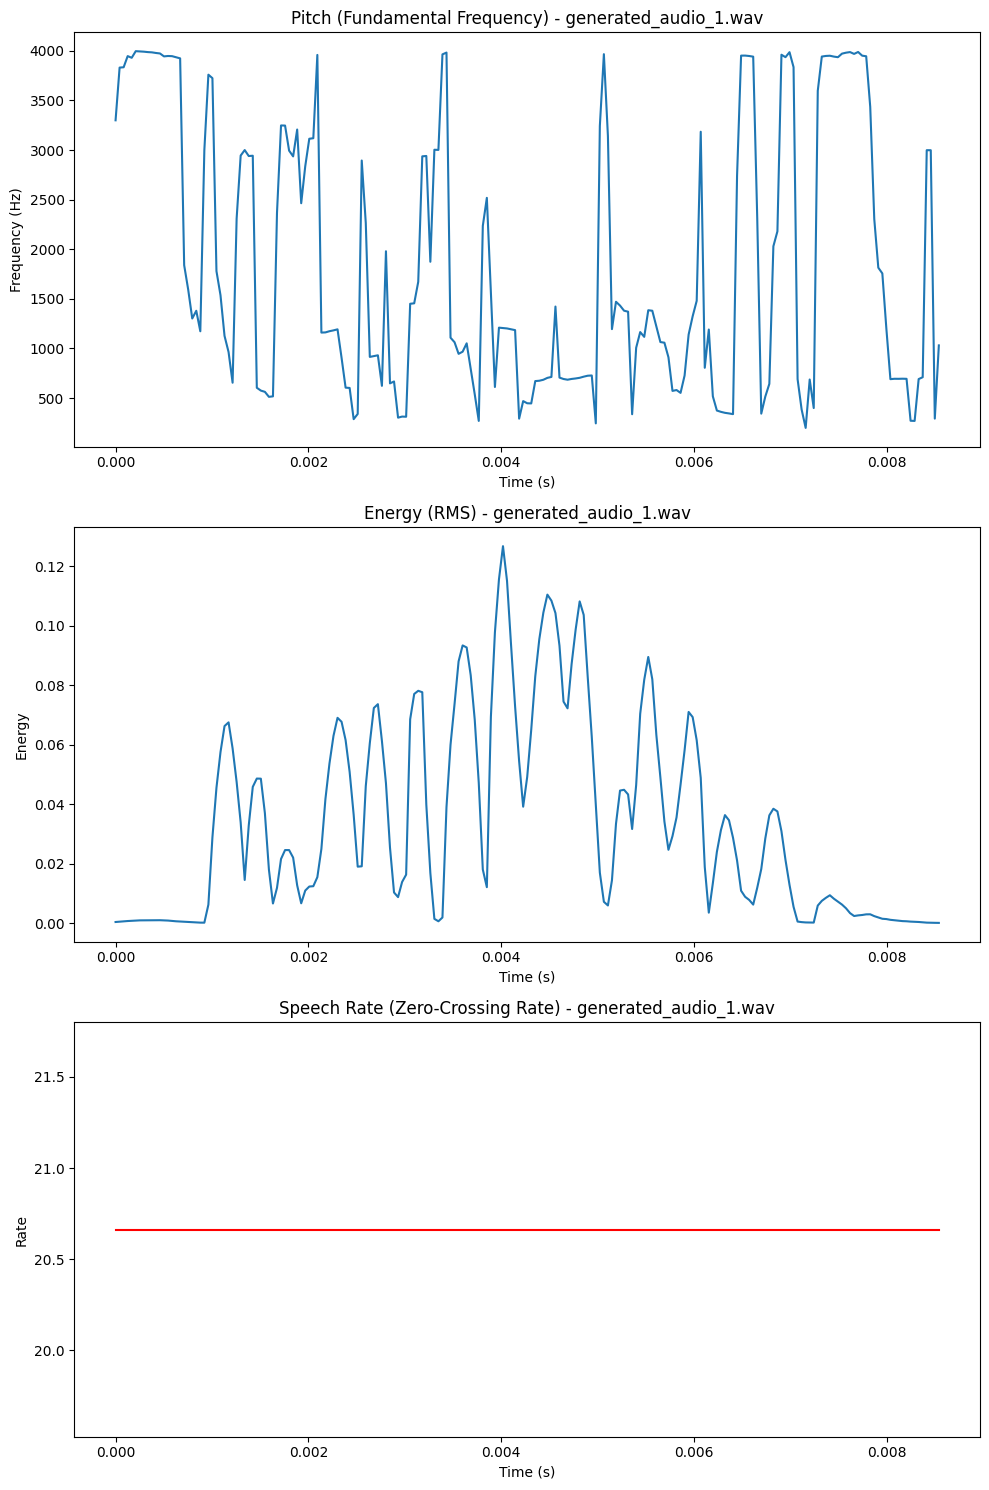

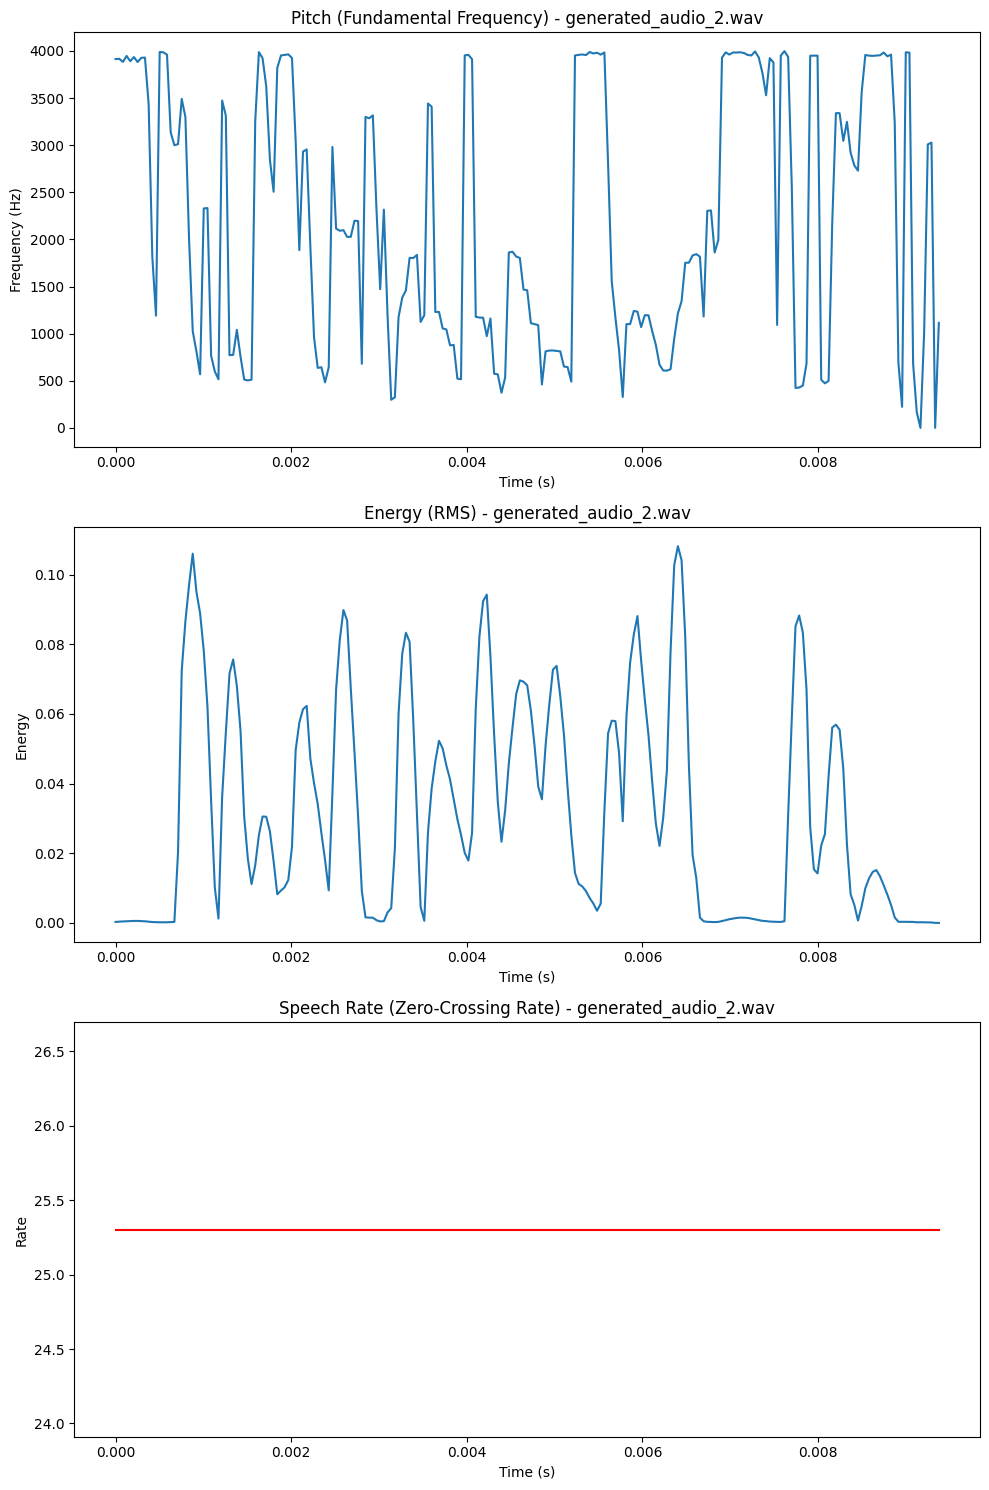

Emotion Score for generated_audio_1.wav: 1883.260498046875
Emotion Score for generated_audio_2.wav: 2231.1572265625
The second file (generated_audio_2.wav) has stronger emotional expression.


In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os

# Function to extract emotional features (Pitch, Energy, and Speech Rate)
def extract_emotional_features(file_path):
    # Load audio file
    y, sr = librosa.load(file_path, sr=None)

    # Pitch (Fundamental Frequency)
    pitches, magnitudes = librosa.core.piptrack(y=y, sr=sr)
    pitch = np.max(pitches, axis=0)

    # Energy (RMS Energy)
    energy = librosa.feature.rms(y=y)[0]

    # Speech Rate (Simple approximation by detecting zero-crossing rate)
    zcr = librosa.feature.zero_crossing_rate(y)[0]
    speech_rate = np.sum(zcr)

    return pitch, energy, speech_rate, sr

# Function to plot emotional features
def plot_emotional_features(file_path, pitch, energy, speech_rate, sr):
    time = np.linspace(0, len(pitch) / sr, len(pitch))

    fig, axs = plt.subplots(3, 1, figsize=(10, 15))

    # Plot Pitch
    axs[0].plot(time, pitch)
    axs[0].set_title(f'Pitch (Fundamental Frequency) - {os.path.basename(file_path)}')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Frequency (Hz)')

    # Plot Energy
    axs[1].plot(time, energy)
    axs[1].set_title(f'Energy (RMS) - {os.path.basename(file_path)}')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Energy')

    # Plot Speech Rate (Zero-Crossing Rate)
    axs[2].plot(time, np.full_like(time, speech_rate), color='red')
    axs[2].set_title(f'Speech Rate (Zero-Crossing Rate) - {os.path.basename(file_path)}')
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('Rate')

    plt.tight_layout()
    plt.show()

# Function to compare emotional features between two audio files
def compare_emotions(file1, file2):
    pitch1, energy1, speech_rate1, sr1 = extract_emotional_features(file1)
    pitch2, energy2, speech_rate2, sr2 = extract_emotional_features(file2)

    # Plot emotional features for both files
    plot_emotional_features(file1, pitch1, energy1, speech_rate1, sr1)
    plot_emotional_features(file2, pitch2, energy2, speech_rate2, sr2)

    # Compute a comparison score based on features (simple average of max values)
    # Higher pitch and energy, and speech rate could indicate stronger emotional expression
    emotion_score1 = np.mean(pitch1) + np.mean(energy1) + speech_rate1
    emotion_score2 = np.mean(pitch2) + np.mean(energy2) + speech_rate2

    # Print out the comparison
    print(f"Emotion Score for {os.path.basename(file1)}: {emotion_score1}")
    print(f"Emotion Score for {os.path.basename(file2)}: {emotion_score2}")

    # Highlight the better emotion (file with higher score)
    if emotion_score2 > emotion_score1:
        print(f"The second file ({os.path.basename(file2)}) has stronger emotional expression.")
    else:
        print(f"The first file ({os.path.basename(file1)}) has stronger emotional expression.")

# List your files here (make sure they're in the same directory or provide full path)
file_paths = ['/content/generated_audio_1.wav', '/content/generated_audio_2.wav']  # Add more .wav files as needed

# Compare emotional expression between the two audio files
for i in range(len(file_paths)):
    for j in range(i + 1, len(file_paths)):
        print(f"\nComparing {file_paths[i]} and {file_paths[j]}")
        compare_emotions(file_paths[i], file_paths[j])

##Final Inference


In [15]:
from flask import Flask, request, send_file
from gtts import gTTS
import os
import tempfile
from sklearn.metrics import classification_report, confusion_matrix
import torch
from transformers import BertForSequenceClassification, RobertaForSequenceClassification, BertTokenizer, RobertaTokenizer
import random
from gtts import gTTS
import os
from gensim.models import KeyedVectors
import nltk
from nltk.corpus import stopwords
import string
import torch
import torchaudio
from unsloth import FastLanguageModel
from snac import SNAC
import numpy as np
from scipy.io.wavfile import write

BASE_MODEL = "unsloth/orpheus-3b-0.1-ft-unsloth-bnb-4bit"
ADAPTER_DIR = "/content/drive/MyDrive/TTS/peft_adapter"

def generate_audio_from_prompt(prompt: str, output_path: str = "output.wav"):
    prompts = [
    f"{prompt}"]

    chosen_voice = None

    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=BASE_MODEL,
        max_seq_length=2048,
        dtype=None,  # auto‑fp16 / bf16
        load_in_4bit=True,
    )
    model.load_adapter(ADAPTER_DIR)

    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

    # Moving snac_model cuda to cpu
    snac_model.to("cpu")

    prompts_= [(f"{chosen_voice}: " + p) if chosen_voice else p for p in prompts]

    all_input_ids = []

    for prompt in prompts_:
      input_ids = tokenizer(prompt, return_tensors="pt").input_ids
      all_input_ids.append(input_ids)

    start_token = torch.tensor([[ 128259]], dtype=torch.int64) # Start of human
    end_tokens = torch.tensor([[128009, 128260]], dtype=torch.int64) # End of text, End of human


    all_modified_input_ids = []
    for input_ids in all_input_ids:
      modified_input_ids = torch.cat([start_token, input_ids, end_tokens], dim=1) # SOH SOT Text EOT EOH
      all_modified_input_ids.append(modified_input_ids)

    all_padded_tensors = []
    all_attention_masks = []
    max_length = max([modified_input_ids.shape[1] for modified_input_ids in all_modified_input_ids])
    for modified_input_ids in all_modified_input_ids:
      padding = max_length - modified_input_ids.shape[1]
      padded_tensor = torch.cat([torch.full((1, padding), 128263, dtype=torch.int64), modified_input_ids], dim=1)
      attention_mask = torch.cat([torch.zeros((1, padding), dtype=torch.int64), torch.ones((1, modified_input_ids.shape[1]), dtype=torch.int64)], dim=1)
      all_padded_tensors.append(padded_tensor)
      all_attention_masks.append(attention_mask)

    all_padded_tensors = torch.cat(all_padded_tensors, dim=0)
    all_attention_masks = torch.cat(all_attention_masks, dim=0)

    input_ids = all_padded_tensors.to("cuda")
    attention_mask = all_attention_masks.to("cuda")
    generated_ids = model.generate(
      input_ids=input_ids,
      attention_mask=attention_mask,
      max_new_tokens=1200,
      do_sample=True,
      temperature=0.6,
      top_p=0.95,
      repetition_penalty=1.1,
      num_return_sequences=1,
      eos_token_id=128258,
      use_cache = True
    )

    token_to_find = 128257
    token_to_remove = 128258

    token_indices = (generated_ids == token_to_find).nonzero(as_tuple=True)

    if len(token_indices[1]) > 0:
      last_occurrence_idx = token_indices[1][-1].item()
      cropped_tensor = generated_ids[:, last_occurrence_idx+1:]
    else:
      cropped_tensor = generated_ids

    mask = cropped_tensor != token_to_remove

    processed_rows = []


    for row in cropped_tensor:
      masked_row = row[row != token_to_remove]
      processed_rows.append(masked_row)

    code_lists = []

    for row in processed_rows:
      row_length = row.size(0)
      new_length = (row_length // 7) * 7
      trimmed_row = row[:new_length]
      trimmed_row = [t - 128266 for t in trimmed_row]
      code_lists.append(trimmed_row)



    def redistribute_codes(code_list):
      layer_1 = []
      layer_2 = []
      layer_3 = []
      for i in range((len(code_list)+1)//7):
        layer_1.append(code_list[7*i])
        layer_2.append(code_list[7*i+1]-4096)
        layer_3.append(code_list[7*i+2]-(2*4096))
        layer_3.append(code_list[7*i+3]-(3*4096))
        layer_2.append(code_list[7*i+4]-(4*4096))
        layer_3.append(code_list[7*i+5]-(5*4096))
        layer_3.append(code_list[7*i+6]-(6*4096))
      codes = [torch.tensor(layer_1).unsqueeze(0),
        torch.tensor(layer_2).unsqueeze(0),
        torch.tensor(layer_3).unsqueeze(0)]

    # codes = [c.to("cuda") for c in codes]
      audio_hat = snac_model.decode(codes)
      return audio_hat

    my_samples = []
    for code_list in code_lists:
      samples = redistribute_codes(code_list)
      my_samples.append(samples)
    from IPython.display import display, Audio
    if len(prompts) != len(my_samples):
      raise Exception("Number of prompts and samples do not match")

    else:
      for i in range(len(my_samples)):
        print(prompts[i])
        # print("EHEHQIUEH")
        samples = my_samples[i]
        display(Audio(samples.detach().squeeze().to("cpu").numpy(), rate=24000))
        save_audio(samples, f"generated_audio.wav")

      # Clean up to save RAM
    del my_samples,samples

In [16]:
from snac import SNAC
snac_model = SNAC.from_pretrained("hubertsiuzdak/snac_24khz")
snac_model = snac_model.to("cuda")

In [17]:
import scipy.io.wavfile as wav

# Define a function to save audio
def save_audio(audio_data, filename="output.wav", sample_rate=24000):
    # Convert audio data to numpy array if it's not already
    audio_data = audio_data.detach().squeeze().cpu().numpy()
    wav.write(filename, sample_rate, audio_data)

In [19]:
import tempfile
import os
from gtts import gTTS
from IPython.display import Audio, display
import random
# Assuming generate_audio_from_prompt and other required functions are already imported

def process_and_generate_audio():
    # Get text input from the user
    text = input("Enter the text: ")

    if not text:
        print("No text provided.")
        return
    sentence=text
    print(sentence)
    # Predict emotion and sentiment
    emotion, sentiment = predict_sample_text(text)
    tokens = nltk.word_tokenize(sentence.lower())
    tokens = [word for word in tokens if word not in string.punctuation]

    # Compute scores
    scores = []
    for word in tokens:
        if word in word_vectors:
            try:
                w2vemo_score = 0.0
                # print(emotion_synonyms['sad'])
                emo_sym=emotion_synonyms.get(emotion)

                for synonym in emo_sym:
                  if synonym in word_vectors:
                    outscore=word_vectors.similarity(word, synonym)
                    if outscore>w2vemo_score:
                        # print("yes")
                        w2vemo_score=outscore
                        # print(w2vemo_score)
                scores.append(w2vemo_score)
            except KeyError:
                scores.append(0.0)
        else:
            scores.append(0.0)


    # Print enhanced sentences
    print(scores)
    enhanced = punctuate_sentence(tokens, scores, emotion, sentiment)
    print(f"Enhanced Sentence for '{sentence}' (Emotion: {emotion}, Sentiment: {sentiment}):")
    print(enhanced)
    print()

    # Generate audio from the enhanced e
    output_file = generate_audio_from_prompt(enhanced)
    print(f"Audio saved to: {output_file}")


    # display(Audio(output_file, rate=24000))

# Run the function
process_and_generate_audio()


Enter the text: I cant wait to go on this vacation this week
I cant wait to go on this vacation this week
tensor([[-0.3376, -0.3009,  0.2240, -0.1675]], device='cuda:0')
SequenceClassifierOutput(loss=None, logits=tensor([[-0.7828,  2.8862, -2.2144]], device='cuda:0'), hidden_states=None, attentions=None)
[0.22592062, 0.37496358, 0.28798687, 0.0, 0.27190104, 0.14571325, 0.118635684, 0.1481215, 0.118635684, 0.165862]
Enhanced Sentence for 'I cant wait to go on this vacation this week' (Emotion: anger, Sentiment: neutral):
i cant. wait to go on this vacation this week

==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloadin

Audio saved to: None
